# Feature Engineering Tasks

From the tasks, it's apparent the data is being prepared for some ML analysis, therefore the tasks are performed keeping this objective in mind. However, the dataset is not being partitioned into the testing and training sets as it is not a requirement in the task.

## Importing Relevant Libraries and Dataset

In [346]:
# Importing Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [347]:
# Load the dataset
data = pd.read_csv("../data/titanic.csv")

# Make a copy of the dataset (in case it's needed later)
copy = data.copy()

## Sub-Task 1: Data Cleaning

### Basic Cleaning

In [348]:
# Considering the final use case of the dataset, I will not attach a primary key to the dataset (which is generally the first step otherwise)

In [349]:
# Removing last row as it contains all null values

data = data.iloc[:-1, :]

In [350]:
# Removing columns that can not affect the survival (attributes related to the time after the accident)

drop_atts=['boat','body','home.dest']
data.drop(drop_atts, inplace=True, axis=1)
data.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S
5,1.0,1.0,"Anderson, Mr. Harry",male,48.0000,0.0,0.0,19952,26.5500,E12,S
6,1.0,1.0,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1.0,0.0,13502,77.9583,D7,S
7,1.0,0.0,"Andrews, Mr. Thomas Jr",male,39.0000,0.0,0.0,112050,0.0000,A36,S
8,1.0,1.0,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2.0,0.0,11769,51.4792,C101,S
9,1.0,0.0,"Artagaveytia, Mr. Ramon",male,71.0000,0.0,0.0,PC 17609,49.5042,NaN,C


In [351]:
# Check missing values

for col in data.columns.tolist():          
    print('{} column missing values: {}'.format(col, data[col].isnull().sum()))
print('\n')

pclass column missing values: 0
survived column missing values: 0
name column missing values: 0
sex column missing values: 0
age column missing values: 263
sibsp column missing values: 0
parch column missing values: 0
ticket column missing values: 0
fare column missing values: 1
cabin column missing values: 1014
embarked column missing values: 2




### Age

In [352]:
# Checking correlation between of age with other numerical features

data_corr = data[['pclass', 'survived', 'sibsp', 'parch', 'fare', 'age']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
data_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
data_corr[data_corr['Feature 1'] == 'age']

,Feature 1,Feature 2,Correlation Coefficient
5,age,age,1.000000
8,age,pclass,0.408106
17,age,sibsp,0.243699
21,age,fare,0.178739
24,age,parch,0.150917
30,age,survived,0.055513


In [353]:
# Using the most correlated feature (pclass) to impute the missing values of age, sex is used as a secondary grouping feature

age_groups = data[['sex', 'age', 'pclass']].groupby(['sex', 'pclass']).median()['age'] # Using median instead of mean because of age having a right skew

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of pclass {} {}s: {}'.format(pclass, sex, age_groups[sex][pclass])) # Confirms that using age as a second grouping feature has impact
print('Median age of all passengers: {}'.format(data['age'].median()))

# Create a new column 'age_fill' to hold the filled values
age_groups = age_groups.reset_index()
median_age_dict = age_groups.set_index(['sex', 'pclass']).to_dict()['age']
data['age_fill'] = data.apply(lambda row: median_age_dict.get((row['sex'], row['pclass']), row['age']), axis=1)

# Use 'age_fill' to fill missing values in the 'age' column
data['age'] = data['age'].fillna(data['age_fill'])
data = data.drop(columns=['age_fill'])

# Confirm that there are no more missing values in the 'age' column
print("\nMissing ages: ", data['age'].isnull().sum())

Median age of pclass 1 females: 36.0
Median age of pclass 1 males: 42.0
Median age of pclass 2 females: 28.0
Median age of pclass 2 males: 29.5
Median age of pclass 3 females: 22.0
Median age of pclass 3 males: 25.0
Median age of all passengers: 28.0

Missing ages:  0


### Embarked

In [354]:
# Check which are missing

data[data['embarked'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
168,1.0,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,B28,NaN
284,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,NaN


In [355]:
# Filling the missing values by researching the actual values (which are coincodentally also the most common values)

# Trying to predict the embarked port from any other column shows no logical basis as the embarked port does not depend on any other column. Since this is the data of the Titanic, we can use the internet to find a such missing value. A quick google search shows that both of the people embarked from Southampton.

# Filling the missing values in embarked with S
data['embarked'] = data['embarked'].fillna('S')

# Confirm that there are no more missing values in the 'embarked' column
print("\nMissing embarked: ", data['embarked'].isnull().sum())


Missing embarked:  0


### Fare

In [356]:
# Checking correlation between of fare with other numerical features

data_corr = data[['pclass', 'survived', 'sibsp', 'parch', 'fare', 'age']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
data_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
data_corr[data_corr['Feature 1'] == 'fare']

,Feature 1,Feature 2,Correlation Coefficient
2,fare,fare,1.000000
7,fare,pclass,0.558629
15,fare,survived,0.244265
17,fare,parch,0.221539
20,fare,age,0.200038
22,fare,sibsp,0.160238


In [357]:
# There is no clear correlation with any other feature except pclass (which was expected), however the people of the same class have different fares. This can be because of the different cabins and the different number of people in each cabin. So, we will use the median fare of each pclass along with their accompanying family as second grouping feature to fill the missing values.

data[data['fare'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
1225,3.0,0.0,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,NaN,S


In [358]:
# Using the most correlated feature (pclass) to impute the missing values of fare, with parch and sibsp used as secondary grouping features

# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
med_fare = data.groupby(['pclass', 'parch', 'sibsp']).fare.median()[3][0][0] # Using median instead of mean because of fare having a right skew
data['fare'] = data['fare'].fillna(med_fare)

# Confirm that there are no more missing values in the 'fare' column
print("\nMissing fares: ", data['fare'].isnull().sum())


Missing fares:  0


### Cabin

In [359]:
# Reasoning:

# Such a column having this many missing values (> 70%) is usually dropped. Either way, I saw the following options:
# 1. Drop the column
# 2. Turn the column into a binary column (1 if cabin is present, 0 if not)
# 3. Fill some values according to people having the same ticket number, and the rest with N/A (or something similar)
# 4. Research the titanic for hints about the cabin numbers and how to fill them

# According to EDA, the column is important. So dropping it is not an option. 
# The fourth option is not feasible in real life problems, it is only possible in this case because the dataset is about the Titanic (which is a well researched topic). 
# The third option fills only about 1/3rd of the values; categorizing the rest as the same category creates a highly skewed distribution.
# The second option is the best option in this case, as it fills all the values and does not create a highly skewed distribution, ensuring we do not lose an important feature while retaining its usability.

# Since the selected option falls under the category of feature extraction, for now we will just fill the missing values with a new category NA.

In [360]:
# Fill missing values with 'NA'
data.cabin = data.cabin.fillna('NA')

# Confirm that there are no more missing values in the 'cabin' column
print("\nMissing cabin: ", data['cabin'].isnull().sum())


Missing cabin:  0


### Final Confirmation

In [361]:
# Confirm that there are no more missing values in the dataset
print("\nRemaining missing values in complete dataset: ", data.isnull().sum().sum())


Remaining missing values in complete dataset:  0


## Sub-Task 2: Feature Extraction

### Title

In [362]:
# As hinted in the task description too, this is extracted from passenger name.

# Extracting the title from the name column and creating a new column 'title'
data['title'] = data['name'].str.split(',|\\.',expand = True)[1] #expand set to True to return a df instead of series
data['title'] = data['title'].str.strip()

data['title'].value_counts() #just display the name column summary

title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Mme               1
Lady              1
Name: count, dtype: int64

In [363]:
# Grouping some titles according to their translation to English from another language

data['title'] = data['title'].replace('Mlle', 'Miss')
data['title'] = data['title'].replace('Ms', 'Miss')
data['title'] = data['title'].replace('Mme', 'Mrs')

data['title'].value_counts() #just display the name column summary

title
Mr              757
Miss            264
Mrs             198
Master           61
Dr                8
Rev               8
Col               4
Major             2
Capt              1
Lady              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Name: count, dtype: int64

In [364]:
# Grouping rare titles together
data['title'] = data['title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

data['title'].value_counts() #just display the name column summary

title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

In [365]:
# No more title groupings needed

# Dropping the name column
data = data.drop(columns=['name'])

data.head(10)

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
0,1.0,1.0,female,29.0000,0.0,0.0,24160,211.3375,B5,S,Miss
1,1.0,1.0,male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,Master
2,1.0,0.0,female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,Miss
3,1.0,0.0,male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,Mr
4,1.0,0.0,female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,Mrs
5,1.0,1.0,male,48.0000,0.0,0.0,19952,26.5500,E12,S,Mr
6,1.0,1.0,female,63.0000,1.0,0.0,13502,77.9583,D7,S,Miss
7,1.0,0.0,male,39.0000,0.0,0.0,112050,0.0000,A36,S,Mr
8,1.0,1.0,female,53.0000,2.0,0.0,11769,51.4792,C101,S,Mrs
9,1.0,0.0,male,71.0000,0.0,0.0,PC 17609,49.5042,NA,C,Mr


### Married

In [366]:
# Married feature is created from the title feature
data['married'] = 0
data['married'].loc[data['title'] == 'Mrs'] = 1

C:\Users\ahsan\AppData\Local\Temp\ipykernel_16100\4268574167.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['married'].loc[data['title'] == 'Mrs'] = 1
C:\Users\ahsan\AppData\Local\Temp\ipykernel_16100\4268574167.py:3: SettingWithCo

### Family Size

In [367]:
# This is the sum of the number of siblings/spouses and the number of parents/children.
data['family_size'] = data['sibsp'] + data['parch'] + 1

# Drop the parch and sibsp columns
data.drop(['sibsp', 'parch'], axis=1, inplace=True)

data.head(10)

,pclass,survived,sex,age,ticket,fare,cabin,embarked,title,married,family_size
0,1.0,1.0,female,29.0000,24160,211.3375,B5,S,Miss,0,1.0
1,1.0,1.0,male,0.9167,113781,151.5500,C22 C26,S,Master,0,4.0
2,1.0,0.0,female,2.0000,113781,151.5500,C22 C26,S,Miss,0,4.0
3,1.0,0.0,male,30.0000,113781,151.5500,C22 C26,S,Mr,0,4.0
4,1.0,0.0,female,25.0000,113781,151.5500,C22 C26,S,Mrs,1,4.0
5,1.0,1.0,male,48.0000,19952,26.5500,E12,S,Mr,0,1.0
6,1.0,1.0,female,63.0000,13502,77.9583,D7,S,Miss,0,2.0
7,1.0,0.0,male,39.0000,112050,0.0000,A36,S,Mr,0,1.0
8,1.0,1.0,female,53.0000,11769,51.4792,C101,S,Mrs,1,3.0
9,1.0,0.0,male,71.0000,PC 17609,49.5042,NA,C,Mr,0,1.0


### Alone

In [368]:
# Alone feature extracted from family size

data['alone'] = 0
data.loc[data['family_size'] == 1, 'alone'] = 1

data.head(10)

,pclass,survived,sex,age,ticket,fare,cabin,embarked,title,married,family_size,alone
0,1.0,1.0,female,29.0000,24160,211.3375,B5,S,Miss,0,1.0,1
1,1.0,1.0,male,0.9167,113781,151.5500,C22 C26,S,Master,0,4.0,0
2,1.0,0.0,female,2.0000,113781,151.5500,C22 C26,S,Miss,0,4.0,0
3,1.0,0.0,male,30.0000,113781,151.5500,C22 C26,S,Mr,0,4.0,0
4,1.0,0.0,female,25.0000,113781,151.5500,C22 C26,S,Mrs,1,4.0,0
5,1.0,1.0,male,48.0000,19952,26.5500,E12,S,Mr,0,1.0,1
6,1.0,1.0,female,63.0000,13502,77.9583,D7,S,Miss,0,2.0,0
7,1.0,0.0,male,39.0000,112050,0.0000,A36,S,Mr,0,1.0,1
8,1.0,1.0,female,53.0000,11769,51.4792,C101,S,Mrs,1,3.0,0
9,1.0,0.0,male,71.0000,PC 17609,49.5042,NA,C,Mr,0,1.0,1


### Has Cabin

In [369]:
# Extension of cleaning of the cabin column - has_cabin = 1 if cabin is present, 0 otherwise
data['has_cabin'] = data["cabin"].apply(lambda x: 0 if x == "NA" else 1)

# Drop the cabin column
data.drop(['cabin'], axis=1, inplace=True)

data.head(10)

,pclass,survived,sex,age,ticket,fare,embarked,title,married,family_size,alone,has_cabin
0,1.0,1.0,female,29.0000,24160,211.3375,S,Miss,0,1.0,1,1
1,1.0,1.0,male,0.9167,113781,151.5500,S,Master,0,4.0,0,1
2,1.0,0.0,female,2.0000,113781,151.5500,S,Miss,0,4.0,0,1
3,1.0,0.0,male,30.0000,113781,151.5500,S,Mr,0,4.0,0,1
4,1.0,0.0,female,25.0000,113781,151.5500,S,Mrs,1,4.0,0,1
5,1.0,1.0,male,48.0000,19952,26.5500,S,Mr,0,1.0,1,1
6,1.0,1.0,female,63.0000,13502,77.9583,S,Miss,0,2.0,0,1
7,1.0,0.0,male,39.0000,112050,0.0000,S,Mr,0,1.0,1,1
8,1.0,1.0,female,53.0000,11769,51.4792,S,Mrs,1,3.0,0,1
9,1.0,0.0,male,71.0000,PC 17609,49.5042,C,Mr,0,1.0,1,0


### Ticket Class

In [370]:
# Extracting the ticket class from the ticket column

data['ticket_class'] = data['ticket'].apply(lambda x: x.split()[0] if len(x.strip().split()) != 1 else "N/A")

data.head(10)

,pclass,survived,sex,age,ticket,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class
0,1.0,1.0,female,29.0000,24160,211.3375,S,Miss,0,1.0,1,1,N/A
1,1.0,1.0,male,0.9167,113781,151.5500,S,Master,0,4.0,0,1,N/A
2,1.0,0.0,female,2.0000,113781,151.5500,S,Miss,0,4.0,0,1,N/A
3,1.0,0.0,male,30.0000,113781,151.5500,S,Mr,0,4.0,0,1,N/A
4,1.0,0.0,female,25.0000,113781,151.5500,S,Mrs,1,4.0,0,1,N/A
5,1.0,1.0,male,48.0000,19952,26.5500,S,Mr,0,1.0,1,1,N/A
6,1.0,1.0,female,63.0000,13502,77.9583,S,Miss,0,2.0,0,1,N/A
7,1.0,0.0,male,39.0000,112050,0.0000,S,Mr,0,1.0,1,1,N/A
8,1.0,1.0,female,53.0000,11769,51.4792,S,Mrs,1,3.0,0,1,N/A
9,1.0,0.0,male,71.0000,PC 17609,49.5042,C,Mr,0,1.0,1,0,PC


### Group Ticket

In [371]:
# Tickets are repeated for people travelling together, causing a difference in fare. So we will use the number of people with the same ticket number as a feature
data['ticket_group'] = data.groupby('ticket').transform('count').iloc[:, 0]

# Drop the ticket column    
data.drop(['ticket'], axis=1, inplace=True)

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group
0,1.0,1.0,female,29.0000,211.3375,S,Miss,0,1.0,1,1,N/A,4
1,1.0,1.0,male,0.9167,151.5500,S,Master,0,4.0,0,1,N/A,6
2,1.0,0.0,female,2.0000,151.5500,S,Miss,0,4.0,0,1,N/A,6
3,1.0,0.0,male,30.0000,151.5500,S,Mr,0,4.0,0,1,N/A,6
4,1.0,0.0,female,25.0000,151.5500,S,Mrs,1,4.0,0,1,N/A,6
5,1.0,1.0,male,48.0000,26.5500,S,Mr,0,1.0,1,1,N/A,1
6,1.0,1.0,female,63.0000,77.9583,S,Miss,0,2.0,0,1,N/A,3
7,1.0,0.0,male,39.0000,0.0000,S,Mr,0,1.0,1,1,N/A,1
8,1.0,1.0,female,53.0000,51.4792,S,Mrs,1,3.0,0,1,N/A,2
9,1.0,0.0,male,71.0000,49.5042,C,Mr,0,1.0,1,0,PC,1


### Fare Per Head

In [372]:
# This is extracted from the ticket_group column

data['fare_per_head'] = data['fare'] / data['ticket_group']

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group,fare_per_head
0,1.0,1.0,female,29.0000,211.3375,S,Miss,0,1.0,1,1,N/A,4,52.834375
1,1.0,1.0,male,0.9167,151.5500,S,Master,0,4.0,0,1,N/A,6,25.258333
2,1.0,0.0,female,2.0000,151.5500,S,Miss,0,4.0,0,1,N/A,6,25.258333
3,1.0,0.0,male,30.0000,151.5500,S,Mr,0,4.0,0,1,N/A,6,25.258333
4,1.0,0.0,female,25.0000,151.5500,S,Mrs,1,4.0,0,1,N/A,6,25.258333
5,1.0,1.0,male,48.0000,26.5500,S,Mr,0,1.0,1,1,N/A,1,26.550000
6,1.0,1.0,female,63.0000,77.9583,S,Miss,0,2.0,0,1,N/A,3,25.986100
7,1.0,0.0,male,39.0000,0.0000,S,Mr,0,1.0,1,1,N/A,1,0.000000
8,1.0,1.0,female,53.0000,51.4792,S,Mrs,1,3.0,0,1,N/A,2,25.739600
9,1.0,0.0,male,71.0000,49.5042,C,Mr,0,1.0,1,0,PC,1,49.504200


## Sub-Task 3: Age Grouping

In [373]:
# Grouping of age groups helps us handle outliers in this column, which are indeed present as well as the fact that the age column is right skewed
# Number of groups is chosen according to hit and trial during EDA

data['age'] = pd.qcut(data['age'], 10)

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group,fare_per_head
0,1.0,1.0,female,"(26.0, 29.5]",211.3375,S,Miss,0,1.0,1,1,N/A,4,52.834375
1,1.0,1.0,male,"(0.166, 16.0]",151.5500,S,Master,0,4.0,0,1,N/A,6,25.258333
2,1.0,0.0,female,"(0.166, 16.0]",151.5500,S,Miss,0,4.0,0,1,N/A,6,25.258333
3,1.0,0.0,male,"(29.5, 34.0]",151.5500,S,Mr,0,4.0,0,1,N/A,6,25.258333
4,1.0,0.0,female,"(22.0, 25.0]",151.5500,S,Mrs,1,4.0,0,1,N/A,6,25.258333
5,1.0,1.0,male,"(40.0, 48.0]",26.5500,S,Mr,0,1.0,1,1,N/A,1,26.550000
6,1.0,1.0,female,"(48.0, 80.0]",77.9583,S,Miss,0,2.0,0,1,N/A,3,25.986100
7,1.0,0.0,male,"(34.0, 40.0]",0.0000,S,Mr,0,1.0,1,1,N/A,1,0.000000
8,1.0,1.0,female,"(48.0, 80.0]",51.4792,S,Mrs,1,3.0,0,1,N/A,2,25.739600
9,1.0,0.0,male,"(48.0, 80.0]",49.5042,C,Mr,0,1.0,1,0,PC,1,49.504200


In [374]:
# Age column is label encoded to further decrease the effect of outliers
data['age'] = LabelEncoder().fit_transform(data['age'])

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group,fare_per_head
0,1.0,1.0,female,5,211.3375,S,Miss,0,1.0,1,1,N/A,4,52.834375
1,1.0,1.0,male,0,151.5500,S,Master,0,4.0,0,1,N/A,6,25.258333
2,1.0,0.0,female,0,151.5500,S,Miss,0,4.0,0,1,N/A,6,25.258333
3,1.0,0.0,male,6,151.5500,S,Mr,0,4.0,0,1,N/A,6,25.258333
4,1.0,0.0,female,3,151.5500,S,Mrs,1,4.0,0,1,N/A,6,25.258333
5,1.0,1.0,male,8,26.5500,S,Mr,0,1.0,1,1,N/A,1,26.550000
6,1.0,1.0,female,9,77.9583,S,Miss,0,2.0,0,1,N/A,3,25.986100
7,1.0,0.0,male,7,0.0000,S,Mr,0,1.0,1,1,N/A,1,0.000000
8,1.0,1.0,female,9,51.4792,S,Mrs,1,3.0,0,1,N/A,2,25.739600
9,1.0,0.0,male,9,49.5042,C,Mr,0,1.0,1,0,PC,1,49.504200


## Sub-Task 4: Fare Binning

In [375]:
# The reason for bare binning is the same as for age grouping.
# The number of bins are chosen in a similar manner as well.


data['fare'] = pd.qcut(data['fare'], 13)

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group,fare_per_head
0,1.0,1.0,female,5,"(83.475, 512.329]",S,Miss,0,1.0,1,1,N/A,4,52.834375
1,1.0,1.0,male,0,"(83.475, 512.329]",S,Master,0,4.0,0,1,N/A,6,25.258333
2,1.0,0.0,female,0,"(83.475, 512.329]",S,Miss,0,4.0,0,1,N/A,6,25.258333
3,1.0,0.0,male,6,"(83.475, 512.329]",S,Mr,0,4.0,0,1,N/A,6,25.258333
4,1.0,0.0,female,3,"(83.475, 512.329]",S,Mrs,1,4.0,0,1,N/A,6,25.258333
5,1.0,1.0,male,8,"(23.25, 26.55]",S,Mr,0,1.0,1,1,N/A,1,26.550000
6,1.0,1.0,female,9,"(56.496, 83.475]",S,Miss,0,2.0,0,1,N/A,3,25.986100
7,1.0,0.0,male,7,"(-0.001, 7.25]",S,Mr,0,1.0,1,1,N/A,1,0.000000
8,1.0,1.0,female,9,"(34.075, 56.496]",S,Mrs,1,3.0,0,1,N/A,2,25.739600
9,1.0,0.0,male,9,"(34.075, 56.496]",C,Mr,0,1.0,1,0,PC,1,49.504200


In [376]:
# Fare column is label encoded to further decrease the effect of outliers
data['fare'] = LabelEncoder().fit_transform(data['fare'])

data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,has_cabin,ticket_class,ticket_group,fare_per_head
0,1.0,1.0,female,5,12,S,Miss,0,1.0,1,1,N/A,4,52.834375
1,1.0,1.0,male,0,12,S,Master,0,4.0,0,1,N/A,6,25.258333
2,1.0,0.0,female,0,12,S,Miss,0,4.0,0,1,N/A,6,25.258333
3,1.0,0.0,male,6,12,S,Mr,0,4.0,0,1,N/A,6,25.258333
4,1.0,0.0,female,3,12,S,Mrs,1,4.0,0,1,N/A,6,25.258333
5,1.0,1.0,male,8,8,S,Mr,0,1.0,1,1,N/A,1,26.550000
6,1.0,1.0,female,9,11,S,Miss,0,2.0,0,1,N/A,3,25.986100
7,1.0,0.0,male,7,0,S,Mr,0,1.0,1,1,N/A,1,0.000000
8,1.0,1.0,female,9,10,S,Mrs,1,3.0,0,1,N/A,2,25.739600
9,1.0,0.0,male,9,10,C,Mr,0,1.0,1,0,PC,1,49.504200


## Sub-Task 5: Encoding Categorical Variables

### Label Encoding the Non-Numeric Features before they are One-Hot Encoded

In [377]:
non_num = ['sex','embarked', 'title', "ticket_class", ] # married, alone, has_cabin, ticket_group are already numeric

for feat in non_num:        
    data[feat] = LabelEncoder().fit_transform(data[feat])

In [378]:
# Update the copy of the dataset (to be used in correlation analysis later, visually easier graph to interpret)
copy = data.copy()

### One-hot encoding the numeric non-ordinal categorical columns

In [379]:
feats = ['pclass', 'sex','embarked', 'title', 'married', 'alone', 'has_cabin', 'ticket_group'] # fare, age are ordinal; ticket_class not used as it has too many variations
enc_feats = []

for feat in feats:
    enc_feat = OneHotEncoder().fit_transform(data[feat].values.reshape(-1, 1)).toarray()
    n = data[feat].nunique()
    cols = ['{}_{}'.format(feat, n) for n in range(1, n + 1)]
    enc_data = pd.DataFrame(enc_feat, columns=cols)
    enc_data.index = data.index
    enc_feats.append(enc_data)

data = pd.concat([data, *enc_feats[:6]], axis=1)


### Check results

In [380]:
data.head(10)

,pclass,survived,sex,age,fare,embarked,title,married,family_size,alone,...,embarked_3,title_1,title_2,title_3,title_4,title_5,married_1,married_2,alone_1,alone_2
0,1.0,1.0,0,5,12,2,1,0,1.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,1,0,12,2,0,0,4.0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0,0,12,2,1,0,4.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1,6,12,2,2,0,4.0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0,3,12,2,3,1,4.0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5,1.0,1.0,1,8,8,2,2,0,1.0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6,1.0,1.0,0,9,11,2,1,0,2.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,1.0,0.0,1,7,0,2,2,0,1.0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,1.0,1.0,0,9,10,2,3,1,3.0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
9,1.0,0.0,1,9,10,0,2,0,1.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## Sub-Task 6: Correlation Analysis

### Analyzing the Pearson Correlation Heatmap

<Axes: title={'center': 'Pearson Correlation of Features'}>

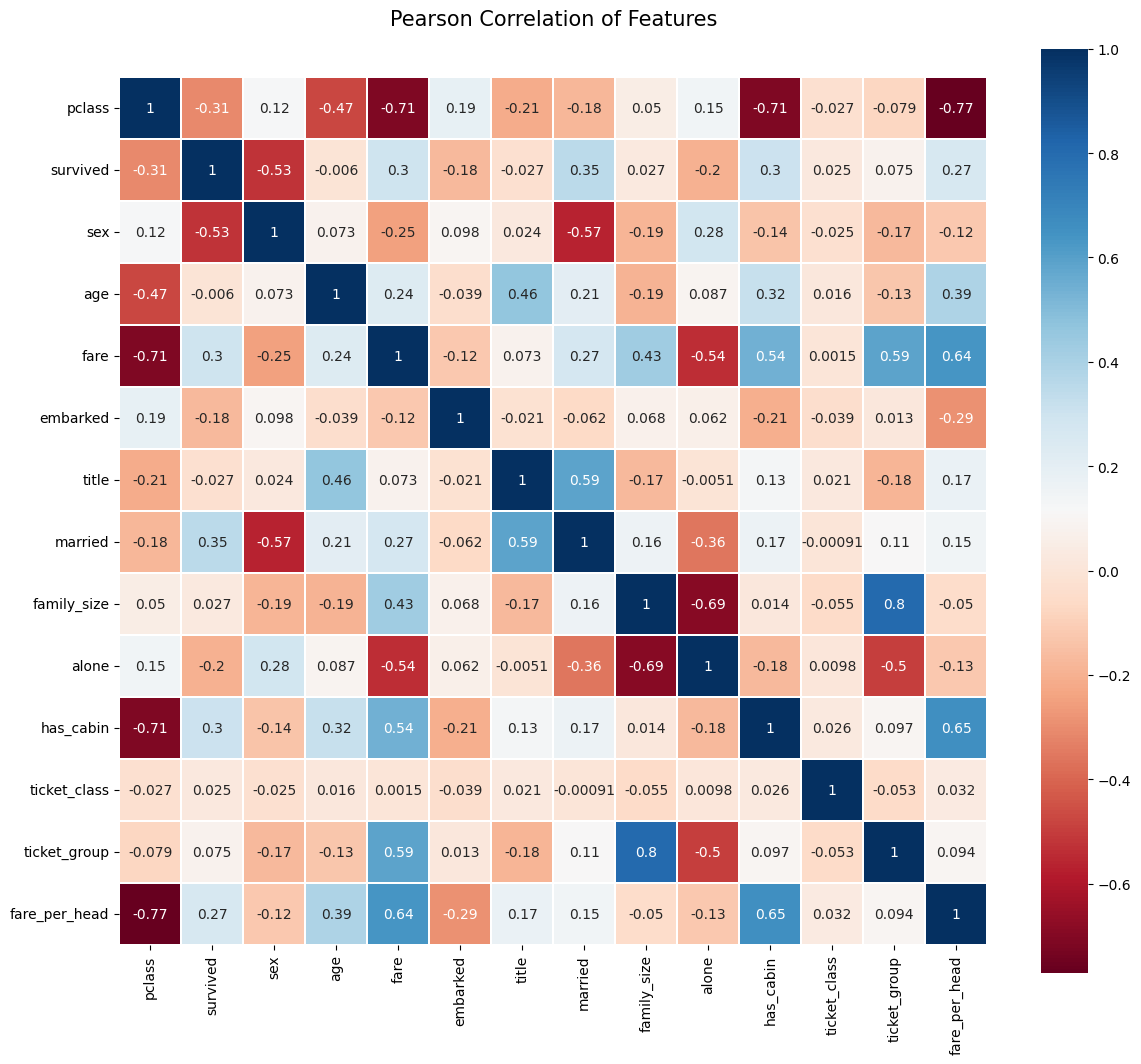

In [381]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(copy.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Separately Analyzing Variable Correlation with Target Variable

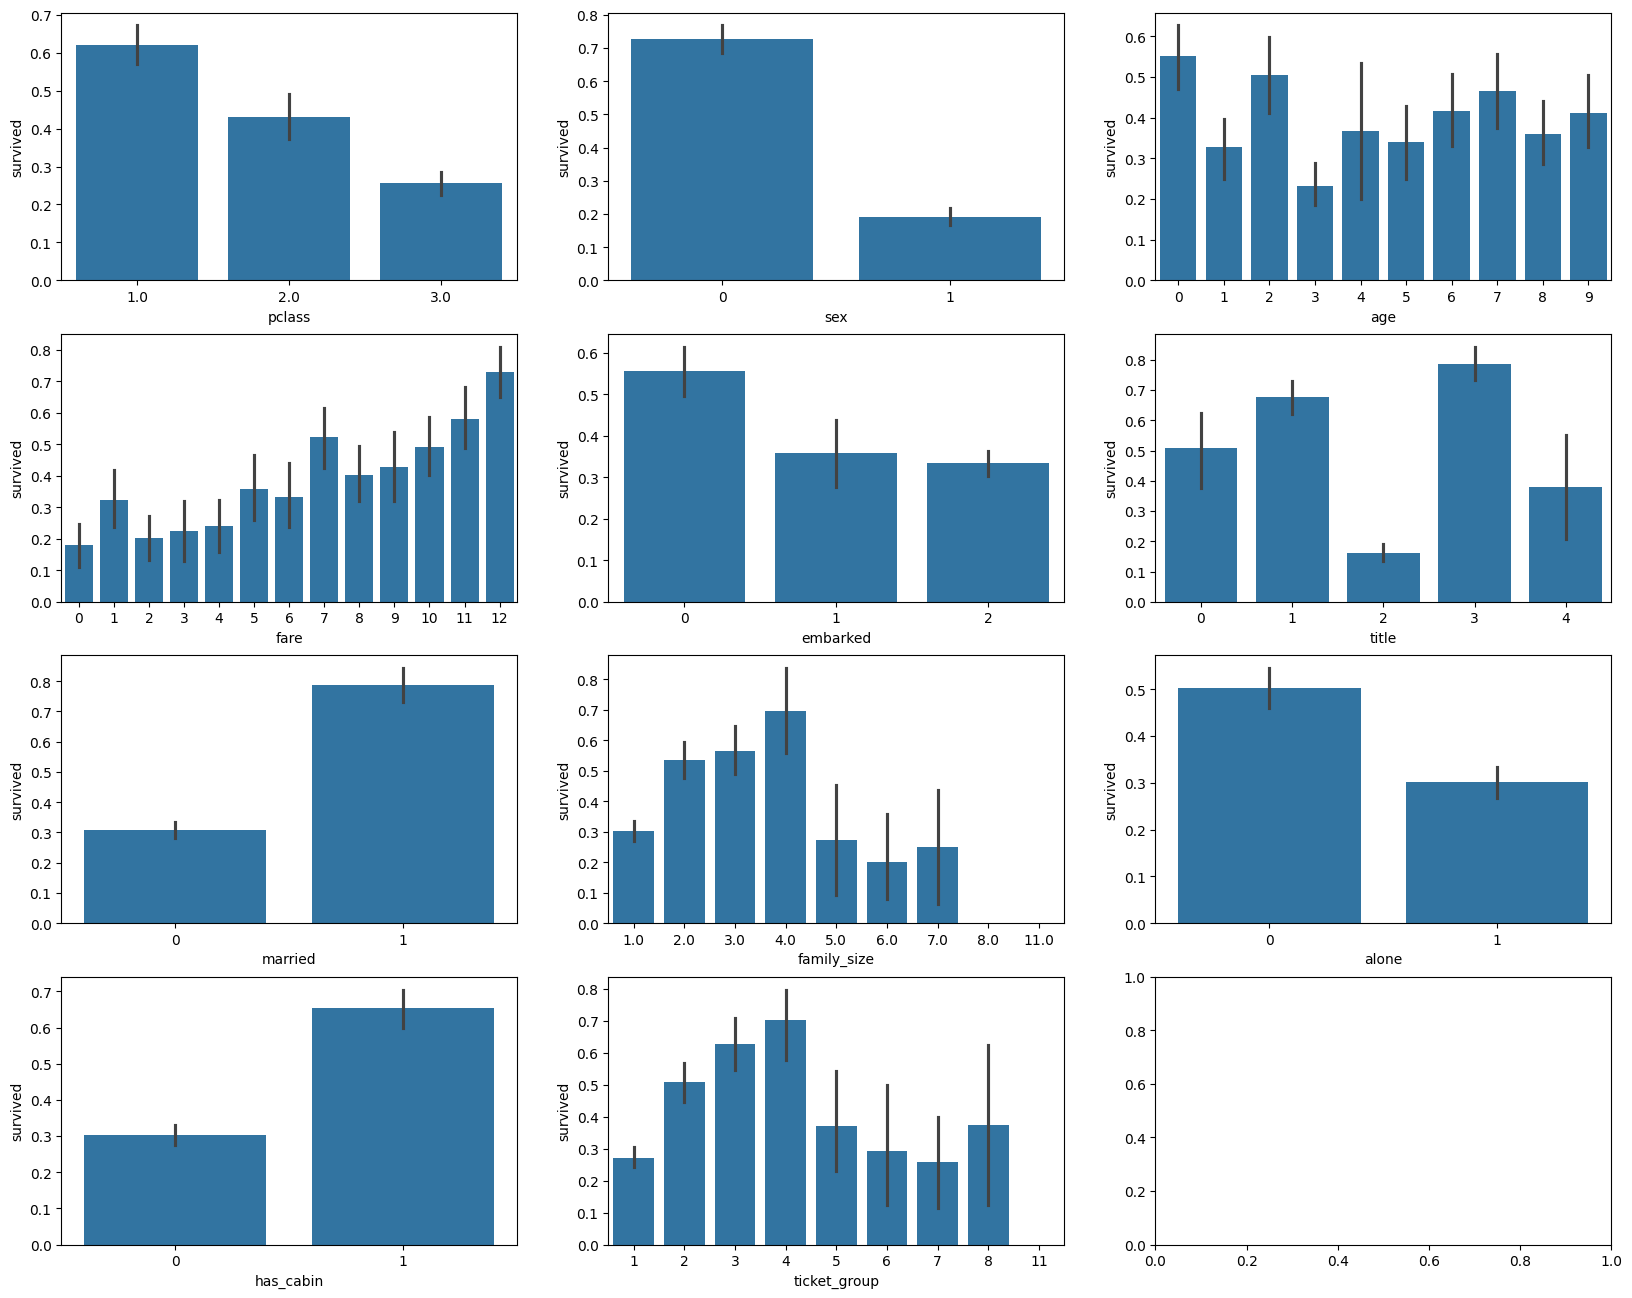

In [382]:
fig, saxis = plt.subplots(4, 3,figsize=(20,16))
 
i = 0
j = 0
for col in copy.columns:
    if col not in ['survived', 'fare_per_head', 'ticket_class']:
        sns.barplot(x = col, y = 'survived', data=copy, ax = saxis[i, j])
        j += 1
        if j == 3:
            j = 0
            i += 1

### Final Analysis 

#### Correlations and their Implications

1. Sex has negatively high correlation with survived, implying women having a higher survival ratio.
1. Age has negatively moderate correlation with pclass, implying that older people rarely buy expensive tickets.
1. Married has negatively high correlation with sex, implying the ratio of married women was more than married men. 
1. Alone has negatively high correlation with fare, implying that people with companions were relatively paying less.
1. Has_cabin has negatively extreme correlation with pclass, implying the expensive classes had more chances of being in a cabin.
1. Fare_per_head has positively high correlation has_cabin, implying that people with cabins paid more fare per head.

1. The following have seemingly obvious implications. They're listed for the sake of complete documentation:
    - Fare has negatively extreme correlation with pclass, implying high fare in expensive classes.
    - Alone has negatively extreme correlation with family_size, since alone = 1 when family_size = 1.
    - Ticket_group has positively extreme correlation with family_size, implying more people on the same ticket increase chances of a larger family size.
    - Ticket_group has negatively high correlation with alone, implying that people who aren't sharing tickets are most likely alone.
    - Fare_per_head has negatively extreme correlation pclass, implying higher per head fare in the expensive classes.
    - Fare_per_head has positively high correlation fare, implying higher fare per head when value of fare is high itself.

#### Survival Correlations (that were not clear from the heatmap correlations, and are inferred from the bar charts)

- **Age:**
    1. Infants and teenagers had the highest survival rate (age label 0).
    1. Interestingly, most oldest passengers survived too (age label 9).
    1. Most deaths were in the age bracket of 16-25 (age labels 1 and 3 to be specific).

- **Pclass and Fare:**
    1. People in the expensive classes had the highest survival rate. 
    1. **Has Cabin:** Similarly, people that had cabins showed higher survival rates.
    1. People in the cheaper classes had a lowest survival rate.

- **Family Size and Ticket Group:**
    1. Large groups/families had lower survival rates.
    1. **Alone:** People travelling alone also had low survival rates.
    1. Small/Medium families/groups had higher survival rates.

- **Sex:**
    1. Women (sex label 0) had a much higher survival rate than men (sex label 1).
    1. **Married:** Within women, married women (married label 1) had a higher survival rate.
    1. **Title:** The title 'Master' (male) had the highest survival rate, with 'Miss' as second highest.

- **Embarked:**
    1. People embarked from port S (label 0) had the higher survival rate.



## Saving Final DataFrame to CSV

In [385]:
data.to_csv('../data/titanic_finalhotencoded.csv', index=False)
copy.to_csv('../data/titanic_finallabelencoded.csv', index=False)